In [1]:
# Cell 1 - Imports and global configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statsmodels for ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Optional: suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")


In [2]:
# Cell 2 - Load weekly feature-engineered data

# Example: CSV saved from feature engineering notebook
weekly = pd.read_csv("aggregated_data\weekly_features.csv", parse_dates=["Date"])

weekly = weekly.sort_values("Date").reset_index(drop=True)

display(weekly.head())
print("Shape:", weekly.shape)


,Date,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,...,avg_qty_per_order,unique_customers,orders_per_customer,returning_times_session,discountrate_times_qty,category_share_Electronics,category_share_Home & Garden,category_share_Sports,category_share_Fashion,category_share_Toys
0,2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,...,2.880597,67,1.000000,8.375139,1.203832,0.519320,0.190078,0.066568,0.090124,0.045320
1,2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,...,3.003937,252,1.007937,8.734252,1.123520,0.419759,0.197702,0.197547,0.058083,0.042290
2,2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,...,2.929104,259,1.034749,9.258075,1.180385,0.365671,0.182891,0.203321,0.116558,0.049825
3,2023-01-23,297780.20,263,781,393.169810,14.292776,9.034221,0.699620,61.752471,0.357414,...,2.969582,251,1.047809,9.999508,1.061371,0.420654,0.162118,0.213596,0.080603,0.044328
4,2023-01-30,304189.39,254,719,440.549055,14.555118,9.070866,0.677165,77.981142,0.413386,...,2.830709,248,1.024194,9.856222,1.170175,0.397646,0.247739,0.150758,0.081904,0.055311


Shape: (65, 84)


In [ ]:
# Cell 3 - Target definition and checks

TARGET = "total_sales"

weekly[[ "Date", TARGET ]].describe()


,Date,total_sales
count,65,65.000000
mean,2023-08-14 00:00:00,335062.347538
min,2023-01-02 00:00:00,80246.010000
25%,2023-04-24 00:00:00,311196.230000
50%,2023-08-14 00:00:00,328604.330000
75%,2023-12-04 00:00:00,360474.010000
max,2024-03-25 00:00:00,456454.260000
std,NaN,50475.658942


In [4]:
# Cell 4 - Time-based train-test split

test_size = int(len(weekly) * 0.2)

train = weekly.iloc[:-test_size].copy()
test  = weekly.iloc[-test_size:].copy()

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 52
Test size: 13


In [5]:
# Cell 5 - Evaluation metrics

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

def evaluate(y_true, y_pred, name="Model"):
    print(f"{name}")
    print(f"RMSE: {rmse(y_true, y_pred):.2f}")
    print(f"MAPE: {mape(y_true, y_pred):.2f}%")
    print(f"ME:   {mean_error(y_true, y_pred):.2f}")
    print("-" * 40)


In [6]:
# Cell 6 - Naïve forecast

last_value = train[TARGET].iloc[-1]

naive_pred = np.repeat(last_value, len(test))

evaluate(test[TARGET], naive_pred, name="Naïve Forecast")


Naïve Forecast
RMSE: 55150.64
MAPE: 11.59%
ME:   24166.15
----------------------------------------


In [7]:
# Cell 7 - Seasonal naïve (4-week lag)

seasonal_lag = 4

seasonal_naive_pred = []

history = list(train[TARGET])

for i in range(len(test)):
    seasonal_naive_pred.append(history[-seasonal_lag])
    history.append(test[TARGET].iloc[i])

seasonal_naive_pred = np.array(seasonal_naive_pred)

evaluate(test[TARGET], seasonal_naive_pred, name="Seasonal Naïve (4-week)")


Seasonal Naïve (4-week)
RMSE: 45033.50
MAPE: 11.33%
ME:   -2801.30
----------------------------------------


In [8]:
# Cell 8 - Moving average forecast

window = 4  # 4-week moving average

ma_pred = []

history = list(train[TARGET])

for i in range(len(test)):
    ma_pred.append(np.mean(history[-window:]))
    history.append(test[TARGET].iloc[i])

ma_pred = np.array(ma_pred)

evaluate(test[TARGET], ma_pred, name="Moving Average (4-week)")


Moving Average (4-week)
RMSE: 51766.68
MAPE: 12.79%
ME:   -94.56
----------------------------------------


In [9]:
# Cell 9 - Fit ARIMA(1,1,1)

arima_model = ARIMA(train[TARGET], order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -639.175
Date:                Sat, 13 Dec 2025   AIC                           1284.351
Time:                        11:19:55   BIC                           1290.146
Sample:                             0   HQIC                          1286.565
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1681      0.183     -0.920      0.358      -0.526       0.190
ma.L1         -0.2706      0.191     -1.415      0.157      -0.645       0.104
sigma2      1.605e+09   4.97e-10   3.23e+18      0.0

In [10]:
# Cell 10 - ARIMA forecast

arima_pred = arima_fit.forecast(steps=len(test))

evaluate(test[TARGET], arima_pred, name="ARIMA(1,1,1)")


ARIMA(1,1,1)
RMSE: 49329.89
MAPE: 13.17%
ME:   -5217.13
----------------------------------------


In [12]:
from prophet import Prophet

In [13]:
# Cell 12 - Prepare data for Prophet

prophet_train = train[["Date", TARGET]].rename(
    columns={"Date": "ds", TARGET: "y"}
)

prophet_test = test[["Date", TARGET]].rename(
    columns={"Date": "ds", TARGET: "y"}
)


In [14]:
# Cell 13 - Prophet model

m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False
)

m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(test), freq="W")
forecast = m.predict(future)

prophet_pred = forecast.iloc[-len(test):]["yhat"].values

evaluate(test[TARGET], prophet_pred, name="Prophet")


11:20:36 - cmdstanpy - INFO - Chain [1] start processing
11:20:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet
RMSE: 304118.92
MAPE: 87.95%
ME:   299958.16
----------------------------------------


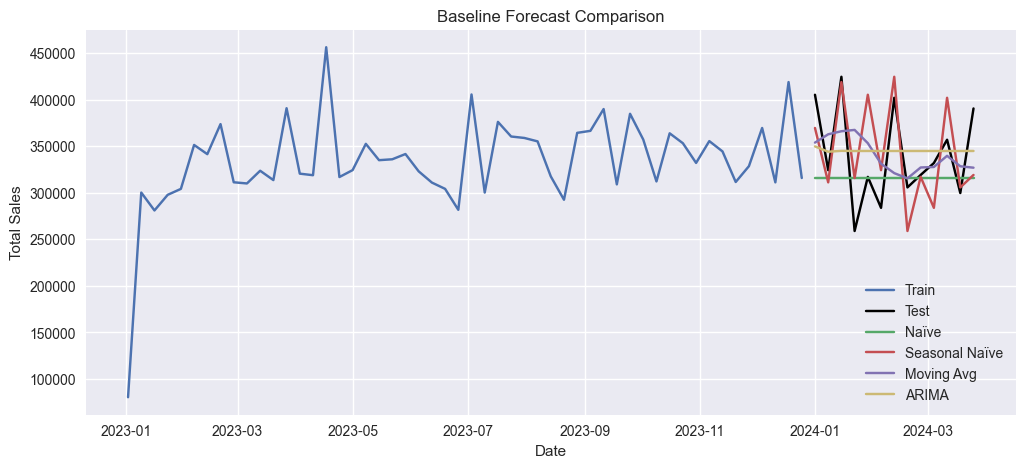

In [15]:
# Cell 14 - Plot forecasts vs actuals

plt.figure(figsize=(12,5))
plt.plot(train["Date"], train[TARGET], label="Train")
plt.plot(test["Date"], test[TARGET], label="Test", color="black")

plt.plot(test["Date"], naive_pred, label="Naïve")
plt.plot(test["Date"], seasonal_naive_pred, label="Seasonal Naïve")
plt.plot(test["Date"], ma_pred, label="Moving Avg")
plt.plot(test["Date"], arima_pred, label="ARIMA")

plt.legend()
plt.title("Baseline Forecast Comparison")
plt.ylabel("Total Sales")
plt.xlabel("Date")
plt.show()


In [16]:
# Cell 15 - Summary metrics table

results = []

models = {
    "Naïve": naive_pred,
    "Seasonal Naïve (4)": seasonal_naive_pred,
    "Moving Avg (4)": ma_pred,
    "ARIMA(1,1,1)": arima_pred
}

for name, preds in models.items():
    results.append({
        "Model": name,
        "RMSE": rmse(test[TARGET], preds),
        "MAPE (%)": mape(test[TARGET], preds),
        "ME": mean_error(test[TARGET], preds)
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values("RMSE"))


,Model,RMSE,MAPE (%),ME
1,Seasonal Naïve (4),45033.500450,11.333832,-2801.303846
3,"ARIMA(1,1,1)",49329.888660,13.174094,-5217.134272
2,Moving Avg (4),51766.676968,12.792325,-94.555192
0,Naïve,55150.640267,11.587657,24166.149231


### Key Observations

- Naïve and seasonal naïve models establish strong lower bounds for performance.
- Moving average smooths volatility but may lag during regime shifts.
- ARIMA captures short-term dynamics but remains limited by small sample size.
- Prophet provides interpretable components but may overfit with only ~65 data points.

These baselines serve as reference points for future machine learning models.
